In [224]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 

In [225]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [226]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)

data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [227]:
# Only selecting SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs7564109"]
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
df["PHENOTYPE"]

0     1
1     1
2     2
3     1
4     1
     ..
84    1
85    2
86    2
87    2
88    2
Name: PHENOTYPE, Length: 89, dtype: object

In [228]:
# Re-encoding SNP of interest

df.loc[df.PHENOTYPE == 2, ['rs2222162']] = 2
df.loc[df.PHENOTYPE == 1, ['rs2222162']] = 0

In [230]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])
dfT = dfTest.T

<AxesSubplot:>

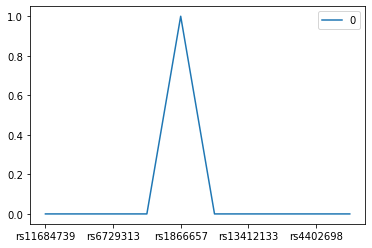

In [252]:
dfT[0]=dfT[0].astype(float)
dfT[0].plot(legend=True) 


<AxesSubplot:>

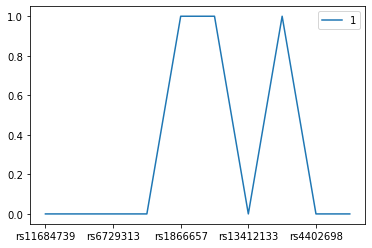

In [254]:
dfT[1]=dfT[1].astype(float)
dfT[1].plot(legend=True) 

<AxesSubplot:>

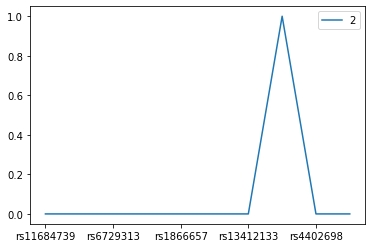

In [256]:
dfT[2]=dfT[2].astype(float)
dfT[2].plot(legend=True) 

<AxesSubplot:>

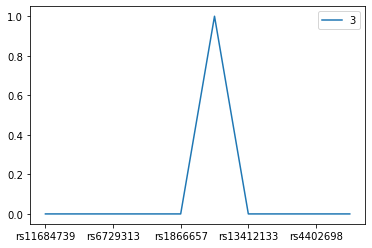

In [255]:
dfT[3]=dfT[3].astype(float)
dfT[3].plot(legend=True) 

In [231]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy='most_frequent')
idf = pd.DataFrame(imp.fit_transform(dfTest))

In [232]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [233]:
# Classifying GWAS data using decision tree and printing results

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtc.fit(xTrain, yTrain)
yPredicted = dtc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = dtc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.7547169811320755
Testing accuracy score: 0.5833333333333334


In [234]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier() 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.7358490566037735
Testing accuracy score: 0.6111111111111112


In [235]:
# Classifying GWAS data using Gaussian Naive Bayes and printing results

gnbClf = GaussianNB() 
gnbClf.fit(xTrain, yTrain)
yPredicted = gnbClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = gnbClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.6226415094339622
Testing accuracy score: 0.5277777777777778


In [236]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [237]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [238]:
# Extracting values from training split
yTrain = yTrain.values
y_test = y_test.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=['index'])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=['index'])

In [239]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [240]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
classifier.score(xTestTransform, yTest)

0.7222222222222222

In [241]:
# Classifying GWAS data using MrSEQL
ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
predicted = ms.predict(xTest)
print("Accuracy with mr-seql: %2.3f" % metrics.accuracy_score(yTest, predicted))

Accuracy with mr-seql: 0.417


<ipython-input-241-0aeb032226af>:2: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="clf")
<ipython-input-241-0aeb032226af>:2: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="clf")
